This tutorial will walk you through how to perform a regression task using supervised machine learning (ML) methods on different types of data that might be relevent for various scientific applications. First we must generate some representative data.

# Generating Data

First, we will generate some nonlinear multi-variate data that will serve as a sufficiently challenging test case for our ML model. The Scikit-Learn library offers some generic routines for generating synthetic data suitable for a range of ML tasks for testing purposes.

In [1]:
# Import the sklearn datasets
import sklearn.datasets as sdt
# Other imports
import numpy as np
import matplotlib.pyplot as plt

For this first example, we will use the Friedman #1 regression function which takes the form: $$f(x)=10sin(\pi x_1 x_2)+ 20(x_3−0.5)^2+10x_4 + 5x_5+ N(0,\sigma) $$

In the following distribution we will create output with 10 features despite the Friedman #1 function only depending upon the first 5 features. We will also add noise to the data to see how well the neural network models can fit perform.

In [2]:
# Create a non-linear distribution using the Friedman #1 function
n_samples = 1000
n_feats = 10
x, y = sdt.make_friedman1(
        n_samples=n_samples,
        n_features=n_feats,
        noise=1.0,
        random_state=42,
)
y = np.expand_dims(y, axis=1)
print(x.shape, y.shape)

(1000, 10) (1000, 1)


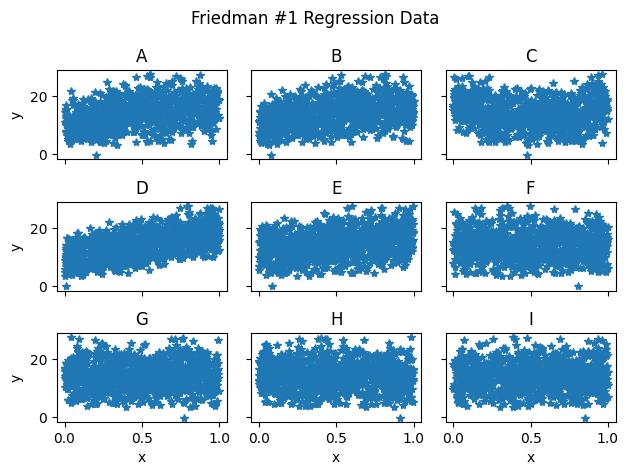

In [3]:
# Visualize the data using a mosaic plot
mosaic = [['A', 'B', 'C'],
          ['D', 'E', 'F'],
          ['G', 'H', 'I']]
fig, axdict = plt.subplot_mosaic(mosaic, sharex=True, sharey=True)
# Loop over all the labels in the mosaic
for idx, ilabel in enumerate(axdict.keys()):
    axdict[ilabel].plot(x[:,idx], y, marker="*", linestyle="None")
    # Set some plot labels
    axdict[ilabel].set_title(ilabel)
    if ilabel in ['A', 'D', 'G']:
        axdict[ilabel].set_ylabel("y")
    if ilabel in ['G', 'H', 'I']:
        axdict[ilabel].set_xlabel("x")

fig.suptitle('Friedman #1 Regression Data')
fig.tight_layout()
plt.show()

# Preprocessing the data
Most ML problems optimally operate on data that is normalized. The type optimal type of normalization depends upon the structure of the data and the desired output.

For this data we will use a rather standard that shifts and scales the data to a distribution centered around 0 with standard deviation equal to 1.

$$ x' = \frac{x - \mu(x)}{\sigma(x)}$$

We can do this manually, or use a number of pre-defined functions in sklearn. Here we will manually define the normalization functions, but in other tutorials we can explore different methods.

When creating a normalization function, it is often useful to also create an inverse normalization function which can be used to convert the ML model predictions back to the physical space.

In [4]:
# Create normalization function
def normalizer(data):
    mean = np.mean(data)
    std = np.std(data)
    data_norm = (data - mean)/std
    return data_norm, mean, std

# Create the inverse normalization function
def inv_normalizer(data, mean, std):
    inv_data = std * data + mean
    return inv_data

# Now scale the data using the normalizers
x_norm, x_mean, x_std = normalizer(x)
y_norm, y_mean, y_std = normalizer(y)

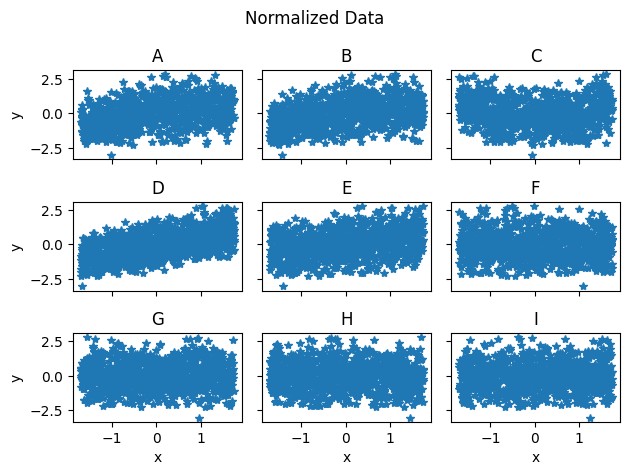

In [5]:
# Visualize the data using a mosaic plot
mosaic = [['A', 'B', 'C'],
          ['D', 'E', 'F'],
          ['G', 'H', 'I']]
fig, axdict = plt.subplot_mosaic(mosaic, sharex=True, sharey=True)
# Loop over all the labels in the mosaic
for idx, ilabel in enumerate(axdict.keys()):
    axdict[ilabel].plot(x_norm[:,idx], y_norm, marker="*", linestyle="None")
    # Set some plot labels
    axdict[ilabel].set_title(ilabel)
    if ilabel in ['A', 'D', 'G']:
        axdict[ilabel].set_ylabel("y")
    if ilabel in ['G', 'H', 'I']:
        axdict[ilabel].set_xlabel("x")

fig.suptitle('Normalized Data')
fig.tight_layout()
plt.show()

# Creating a ML Model
Now that the data is preprocessed nicely, let's create a standard feed-forward neural network and train it to learn the relationship between the features (x) and the output (y).

The initial model will be have an input layer, three hidden layer with the number of neurons defined by the `width` variable, and an output layer.

The number of hidden layers, neurons per layer, and a variety of other "hyperparameters" will have a noticable impact on model results. These values can require extensive tuning depending on the problem at hand.

In [6]:
# Import PyTorch and related modules
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchinfo import summary

# Create a class for the PyTorch model
class ANN(nn.Module):
    def __init__(self, num_feat, width, **kwargs):
        super(ANN, self).__init__(**kwargs)

        self.num_feat = num_feat
        self.width = width
        
        # One Dense layer connecting inputs to bulk layers
        self.dense_layer_in = nn.Linear(self.num_feat, self.width)
        # Bulk layers
        self.bulk1 = nn.Linear(self.width, self.width)
        self.bulk2 = nn.Linear(self.width, self.width)
        self.bulk3 = nn.Linear(self.width, self.width)
        # Output layer with one feature
        self.output_layer = nn.Linear(self.width, 1)
        
    def forward(self, inputs):
        x = inputs

        # Call the input layer connecting the input feature to hidden layers
        x = self.dense_layer_in(x)
        x = F.relu(x)
        # Call the three hidden layers with activation functions to follow
        x = self.bulk1(x)
        x = F.relu(x)
        x = self.bulk2(x)
        x = F.relu(x)
        x = self.bulk3(x)
        x = F.relu(x)
        # Call the output layer and return 
        x = self.output_layer(x)
        return x

# Set some model parameters
width = 8
learning_rate = 1e-3

model = ANN(num_feat=n_feats, width=width)
print(summary(model, input_size=(1, n_feats)))

# Define the loss function and optimizer for training
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Layer (type:depth-idx)                   Output Shape              Param #
ANN                                      [1, 1]                    --
├─Linear: 1-1                            [1, 8]                    88
├─Linear: 1-2                            [1, 8]                    72
├─Linear: 1-3                            [1, 8]                    72
├─Linear: 1-4                            [1, 8]                    72
├─Linear: 1-5                            [1, 1]                    9
Total params: 313
Trainable params: 313
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


# Creating Train, Validation, and Test Datasets
We will now divide our dataset into three subdatasets for training, validation, and testing.

* Training Dataset: The dataset that we will use to optimize our ML model.
* Validation Dataset: A small, unseen dataset that we will use to monitor the performance of the ML model during training time. This can be useful for tuning hyperparameters and determining if the ML model is overfitting to the seen data.
* Test Dataset: Unseen data that is used to determine the overall performance of the fully-trained model.

In [7]:
from sklearn.model_selection import train_test_split

# Ensure numpy arrays are in float32, not float64
x_norm = np.float32(x_norm)
y_norm = np.float32(y_norm)

# Generate train and test datasets with 80-20 split
x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.20, random_state=42)
# Further split the test set into a validation set (final split is 80-10-10)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# precompute the unnormalized versions of y
y_train_real = inv_normalizer(y_train, y_mean, y_std)
y_val_real = inv_normalizer(y_val, y_mean, y_std)
y_test_real = inv_normalizer(y_test, y_mean, y_std)

In [8]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32

# Create the data holder for training/validation (the test set should be held separate from any model training)
dataset = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
dataset_val = TensorDataset(torch.from_numpy(x_val), torch.from_numpy(y_val))

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

# Training the ML Model
Finally, we will train the ML model.

In [9]:
# Set some parameters for the learning loop
width = 8
num_epochs = 100
l1_norm = 0.0
l2_norm = 1e-3
learning_rate = 1e-3

# Make a history dict for storing metrics
history = {"loss": [], "val_loss": []}

# Instantiate the model
model = ANN(num_feat=n_feats, width=width)

# Define the loss function and optimizer for training
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
# Now we can train the model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    val_loss = 0.0
    
    for idx, data in enumerate(dataloader):
        xin, y_truth = data

        # Clear previous gradients
        optimizer.zero_grad()
        
        # forward pass and compute loss
        pred = model(xin)
        loss = criterion(pred, y_truth)

        # add L1 regularization
        l1_reg = torch.tensor(0., requires_grad=True)
        for name, param in model.named_parameters():
            if 'weight' in name:
                l1_reg = l1_reg + torch.norm(param, 1)
        loss = loss + l1_norm * l1_reg

        # add L2 regularization
        l2_reg = torch.tensor(0., requires_grad=True)
        for name, param in model.named_parameters():
            if 'weight' in name:
                l2_reg = l2_reg + torch.norm(param, 2)
        loss = loss + l2_norm * l2_reg

        # Zero out the gradients, perform a backward pass, and update weights
        loss.backward()
        optimizer.step()

        # accumulate loss
        running_loss += loss.item() - (l2_norm * l2_reg).item() - (l1_norm * l1_reg).item()
    running_loss /= len(dataloader)

    # Compute the validation loss
    with torch.no_grad():
        for data_val in dataloader_val:
            xin_val, y_truth_val = data_val
            pred_val = model(xin_val)
            loss_val = criterion(pred_val, y_truth_val)
            val_loss += loss_val.item()
        val_loss /= len(dataloader_val)

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch = {epoch+1}, loss = {running_loss}, val_loss = {val_loss}")
    history["loss"].append(running_loss)
    history["val_loss"].append(val_loss)

Epoch = 1, loss = 0.09368398025631905, val_loss = 0.09222407639026642
Epoch = 10, loss = 0.08730754923075437, val_loss = 0.0815812200307846
Epoch = 20, loss = 0.08243030410259962, val_loss = 0.07971371803432703
Epoch = 30, loss = 0.07526704370975494, val_loss = 0.0713855354115367
Epoch = 40, loss = 0.06962835941463709, val_loss = 0.06579914409667253
Epoch = 50, loss = 0.06536440145224333, val_loss = 0.05989027861505747
Epoch = 60, loss = 0.06301892872899771, val_loss = 0.08712160959839821
Epoch = 70, loss = 0.06027124598622322, val_loss = 0.08767468295991421
Epoch = 80, loss = 0.060530244894325735, val_loss = 0.06468011625111103
Epoch = 90, loss = 0.0577322556078434, val_loss = 0.0673118382692337
Epoch = 100, loss = 0.05704497501254082, val_loss = 0.0583332534879446


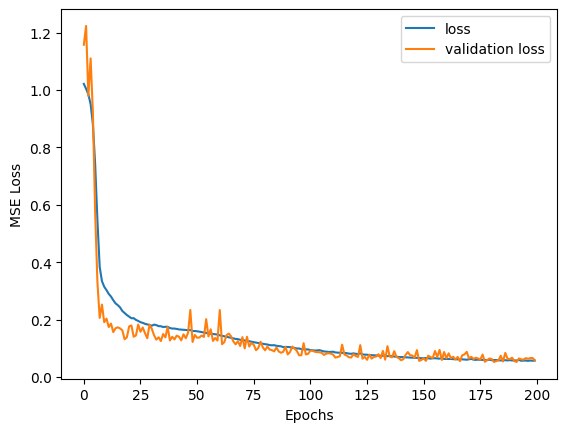

In [15]:
# Plot the loss function over time
fig, ax = plt.subplots(1, 1)
ax.plot(history["loss"], label="loss")
ax.plot(history["val_loss"], label="validation loss")
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("MSE Loss")
plt.show()

In [16]:
# Evaluate the model performance on train and validation data
pred_norm = model(torch.from_numpy(x_norm))
pred_norm_train = model(torch.from_numpy(x_train))
pred_norm_val = model(torch.from_numpy(x_val))
pred_norm_test = model(torch.from_numpy(x_test))

# Unscale the results and plot
pred_full = inv_normalizer(pred_norm, y_mean, y_std).detach().numpy()
pred_train = inv_normalizer(pred_norm_train, y_mean, y_std).detach().numpy()
pred_val = inv_normalizer(pred_norm_val, y_mean, y_std).detach().numpy()
pred_test = inv_normalizer(pred_norm_test, y_mean, y_std).detach().numpy()

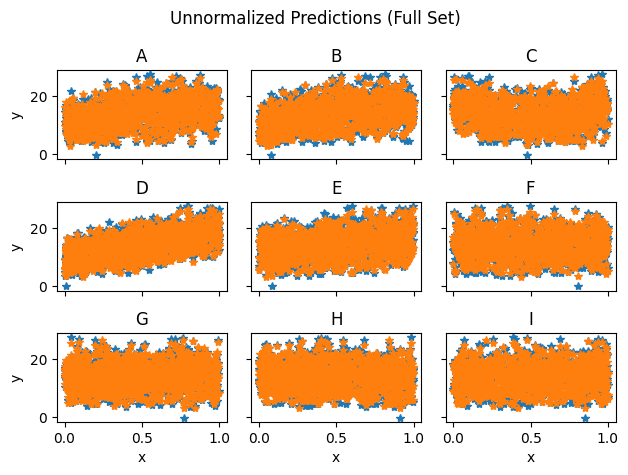

In [13]:
# Visualize the data using a mosaic plot
mosaic = [['A', 'B', 'C'],
          ['D', 'E', 'F'],
          ['G', 'H', 'I']]
fig, axdict = plt.subplot_mosaic(mosaic, sharex=True, sharey=True)
# Loop over all the labels in the mosaic
for idx, ilabel in enumerate(axdict.keys()):
    axdict[ilabel].plot(x[:,idx], y, marker="*", linestyle="None", label="truth")
    axdict[ilabel].plot(x[:,idx], pred_full, marker="*", linestyle="None", label="pred")
    # Set some plot labels
    axdict[ilabel].set_title(ilabel)
    if ilabel in ['A', 'D', 'G']:
        axdict[ilabel].set_ylabel("y")
    if ilabel in ['G', 'H', 'I']:
        axdict[ilabel].set_xlabel("x")

fig.suptitle('Unnormalized Predictions (Full Set)')
fig.tight_layout()
plt.show()

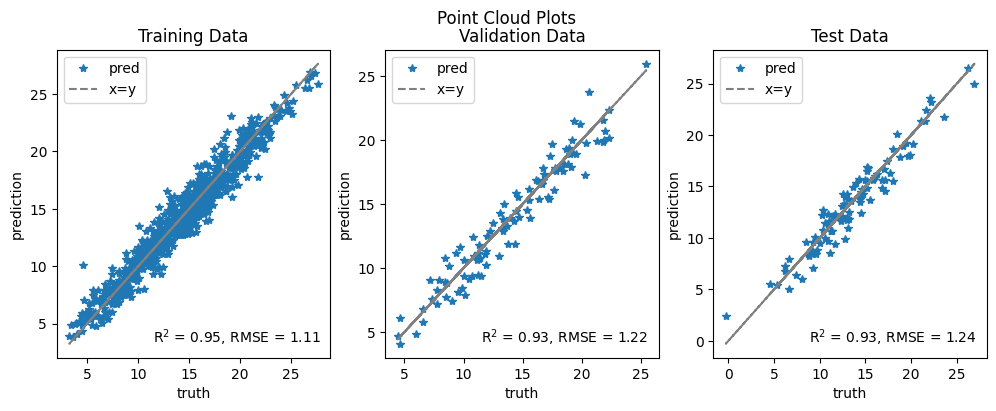

In [17]:
# Compute some statistics on the fit
def pred_stats(pred, truth):
    rss = np.sum((pred - truth) ** 2)
    tss = np.sum((truth - np.mean(truth)) ** 2)
    r_sq = 1 - rss / tss
    rmse = np.squeeze(np.sqrt(np.sum((truth-pred)**2, axis=0)/pred.shape[0]))
    return r_sq, rmse
    
# Training data
r_sq_train, rmse_train = pred_stats(pred_train, y_train_real)
r_sq_val, rmse_val = pred_stats(pred_val, y_val_real)
r_sq_test, rmse_test = pred_stats(pred_test, y_test_real)

# Visualize the predictions using a cloud plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
# Train plot
ax1.plot(y_train_real, pred_train, marker="*", linestyle="None", label="pred")
ax1.plot(y_train_real, y_train_real, linestyle="dashed", label="x=y", color="grey")
ax1.text(x=0.35, y=0.05, s=rf"R$^2$ = {r_sq_train:0.2f}, RMSE = {rmse_train:0.2f}", transform=ax1.transAxes)
ax1.legend()
ax1.set_xlabel("truth")
ax1.set_ylabel("prediction")
ax1.set_title("Training Data")
# Validation plot
ax2.plot(y_val_real, pred_val, marker="*", linestyle="None", label="pred")
ax2.plot(y_val_real, y_val_real, linestyle="dashed", label="x=y", color="grey")
ax2.text(x=0.35, y=0.05, s=rf"R$^2$ = {r_sq_val:0.2f}, RMSE = {rmse_val:0.2f}", transform=ax2.transAxes)
ax2.legend()
ax2.set_xlabel("truth")
ax2.set_ylabel("prediction")
ax2.set_title("Validation Data")
# Test plot
ax3.plot(y_test_real, pred_test, marker="*", linestyle="None", label="pred")
ax3.plot(y_test_real, y_test_real, linestyle="dashed", label="x=y", color="grey")
ax3.text(x=0.35, y=0.05, s=rf"R$^2$ = {r_sq_test:0.2f}, RMSE = {rmse_test:0.2f}", transform=ax3.transAxes)
ax3.legend()
ax3.set_xlabel("truth")
ax3.set_ylabel("prediction")
ax3.set_title("Test Data")

fig.suptitle('Point Cloud Plots')
plt.show()

# Exploration
Exploration of different hyperparameters can have a large impact on the training of the model. These are some examples of hyperparameters that can be examined in more detail:

## Hyperparameters to explore
* Model depth and width
* Layer regularization
* Layer initialization
* Learning rate
* Batch normalization
* Dropout layers
* Activation functions

# Using PT-MELT (PyTorch Machine Learning Toolbox)
Coming soon!